In [2]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Flatten, Dropout, Add, MaxPool2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def residual_block(x, kernel_size, filters, layers=2):
    shortcut_x = x

    for l in range(layers):
        x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        x = BatchNormalization()(x)

        if l == layers-1:
            if K.int_shape(x) != K.int_shape(shortcut_x):
                shortcut_x = Conv2D(filters=filters, kernel_size=(1,1), padding='same')(shortcut_x)

            x = Add()([x, shortcut_x])

        x = LeakyReLU(alpha=0.1)(x)

    return x


In [4]:
def build_model(input_shape, blocks, block_sets, kernel_size=(3,3), first_filters=32, block_layers=2):

    inputs = Input(shape=input_shape)

    # 入力層
    x = Conv2D(filters=first_filters, kernel_size=kernel_size, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # 畳み込み層
    for s in range(block_sets):
        # blockset単位でfilter数を2倍にしていく
        filters = first_filters * (2**s)

        for b in range(blocks):
            x = residual_block(x, kernel_size, filters, block_layers)

        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.3)(x)

    # 出力層
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model

170500096/170498071 [==============================] - 4s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
____________________

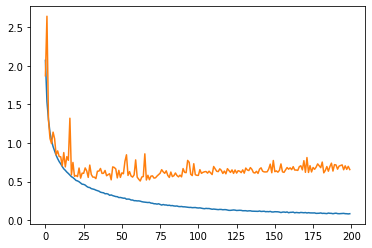

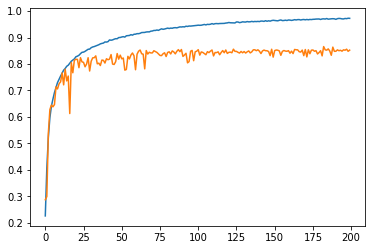

In [5]:
# データロード
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 0~1に正規化
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

input_shape = x_train.shape[1:]
train_samples = x_train.shape[0]
test_samples = x_test.shape[0]

# ハイパーパラメータ
epochs = 200
batch_size = 64

optimizer=Adam()

# resnetモデル
model = build_model(input_shape, blocks=3, block_sets=3)
model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()
